# Diagnosing Biased Inference with Divergences

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from collections import defaultdict

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

SEED = [20100425, 20100234]

%config InlineBackend.figure_format = 'retina'

Runing on PyMC3 v3.3


** PyMC3 port of [Michael Betancourt's post on ms-stan](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html). For detailed explanation of the underlying mechanism please check [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) and Betancourt's [excellent paper](https://arxiv.org/abs/1701.02434).**  
  
Bayesian statistics is all about building a model and estimating the parameters in that model. However, a naive or direct parameterization of our probability model can sometimes be ineffective ([you can check out Thomas Wiecki's blog post on the same issue in PyMC3](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/)). Suboptimal parameterization is often lead to slow sampling, and more problematic, biased MCMC estimators. 

** More formally, as explained in [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) (in markdown block, same below):**  
> 
Markov chain Monte Carlo (MCMC) approximates expectations with respect to a given target distribution, $$ \mathbb{E}{\pi} [ f ] = \int \mathrm{d}q \, \pi (q) \, f(q), $$ using the states of a Markov chain, ${q{0}, \ldots, q_{N} }$, $$ \mathbb{E}{\pi} [ f ] \approx \hat{f}{N} = \frac{1}{N + 1} \sum_{n = 0}^{N} f(q_{n}). $$  
> 
>These estimators, however, are guaranteed to be accurate only asymptotically as the chain grows to be infinitely long, $$ \lim_{N \rightarrow \infty} \hat{f}{N} = \mathbb{E}{\pi} [ f ]. $$  
> 
To be useful in applied analyses, we need MCMC estimators to converge to the true expectation values sufficiently quickly that they are reasonably accurate before we exhaust our finite computational resources. This fast convergence requires strong ergodicity conditions to hold, in particular geometric ergodicity between a Markov transition and a target distribution. Geometric ergodicity is usually the necessary condition for MCMC estimators to follow a central limit theorem, which ensures not only that they are unbiased even after only a finite number of iterations but also that we can empirically quantify their precision using the MCMC standard error.
> 
Unfortunately, proving geometric ergodicity theoretically is infeasible for any nontrivial problem. Instead we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved MCMC estimators. For a general Markov transition and target distribution, the best known diagnostic is the split $\hat{R}$ statistic over an ensemble of Markov chains initialized from diffuse points in parameter space; to do any better we need to exploit the particular structure of a given transition or target distribution.
> 
Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore.

In this notebook we aim to replicate the identification of divergences sample and the underlying pathologies in `PyMC3` similar to [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html).

## The Eight Schools Model
> 
The hierarchical model of the the Eight Schools dataset (Rubin 1981) as seen in `Stan`:
$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\theta_{n} \sim \mathcal{N}(\mu, \tau)$$
$$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$$  
> 
where $n \in \{1, \ldots, 8 \}$ and the $\{ y_{n}, \sigma_{n} \}$ are given as data.  
> 
Inferring the hierarchical hyperparameters, $\mu$ and $\sigma$, together with the group-level parameters, $\theta_{1}, \ldots, \theta_{8}$, allows the model to pool data across the groups and reduce their posterior variance. Unfortunately, the direct *centered* parameterization also squeezes the posterior distribution into a particularly challenging geometry that obstructs geometric ergodicity and hence biases MCMC estimation.

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float)
# tau = 25.

## A Centered Eight Schools Implementation  

`Stan` model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
```
Similarly, we can easily implemented it in `PyMC3`

In [3]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

> Unfortunately, this direct implementation of the model exhibits a pathological geometry that frustrates geometric ergodicity. Even more worrisome, the resulting bias is subtle and may not be obvious upon inspection of the Markov chain alone. To understand this bias, let's consider first a short Markov chain, commonly used when computational expediency is a motivating factor, and only afterwards a longer Markov chain.

### A Dangerously-Short Markov Chain

In [4]:
with Centered_eight:
    short_trace = pm.sample(600, chains=2, random_seed=SEED)

100%|██████████| 1100/1100 [00:05<00:00, 190.06it/s]


In the [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) a single chain of 1200 sample is applied. However, since split $\hat{R}$ is not implemented in `PyMC3` we fit 2 chains with 600 sample each instead.  

The Gelman-Rubin diagnostic $\hat{R}$ doesn’t indicate any problems (values are all close to 1) and the effective sample size per iteration is reasonable

In [5]:
pm.summary(short_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.679453,3.431149,0.177705,-1.600839,11.539732,303.0,1.003413
theta__0,6.894848,6.015114,0.272353,-3.220496,19.865092,339.0,1.004454
theta__1,5.100290,4.960224,0.204394,-4.542910,14.705394,506.0,0.999547
theta__2,4.180726,5.440928,0.236852,-6.698152,14.853667,525.0,0.999904
theta__3,4.995769,4.908261,0.215501,-4.555217,15.079219,429.0,0.999332
theta__4,3.799178,4.788673,0.200070,-6.419205,12.645952,463.0,1.004766
theta__5,4.357757,5.143795,0.199723,-6.617360,14.510525,519.0,0.999286
theta__6,6.928564,5.500795,0.238286,-3.561688,17.109287,384.0,1.002125
theta__7,5.047927,5.614286,0.215961,-5.428309,16.242407,522.0,0.999975
tau,4.249715,3.074726,0.193371,0.686836,9.849278,179.0,1.000399


> Moreover, the trace plots all look fine. Let's consider, for example, the hierarchical standard deviation $\tau$, or more specifically, its logarithm, $log(\tau)$. Because $\tau$ is constrained to be positive, its logarithm will allow us to better resolve behavior for small values. Indeed the chains seems to be exploring both small and large values reasonably well,

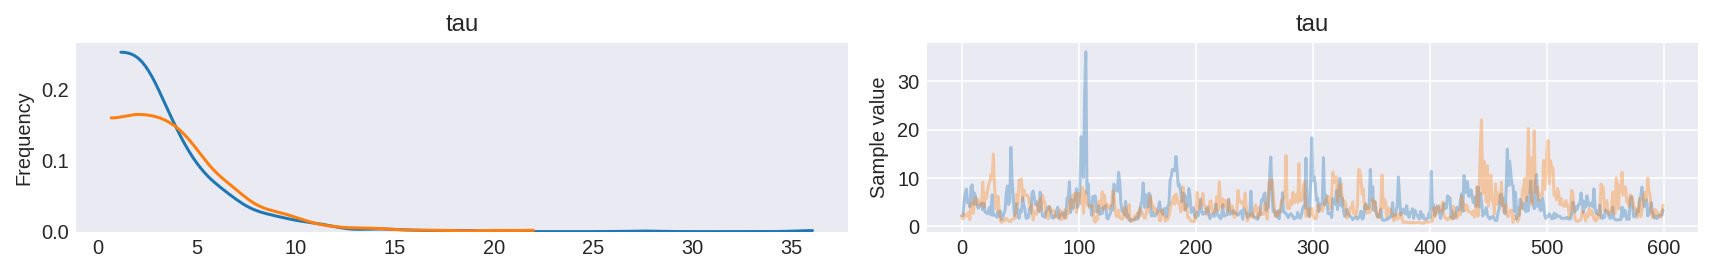

In [6]:
# plot the trace of log(tau)
pm.traceplot(short_trace, varnames=['tau']);

> Unfortunately, the resulting estimate for the mean of $log(\tau)$ is strongly biased away from the true value, here shown in grey.

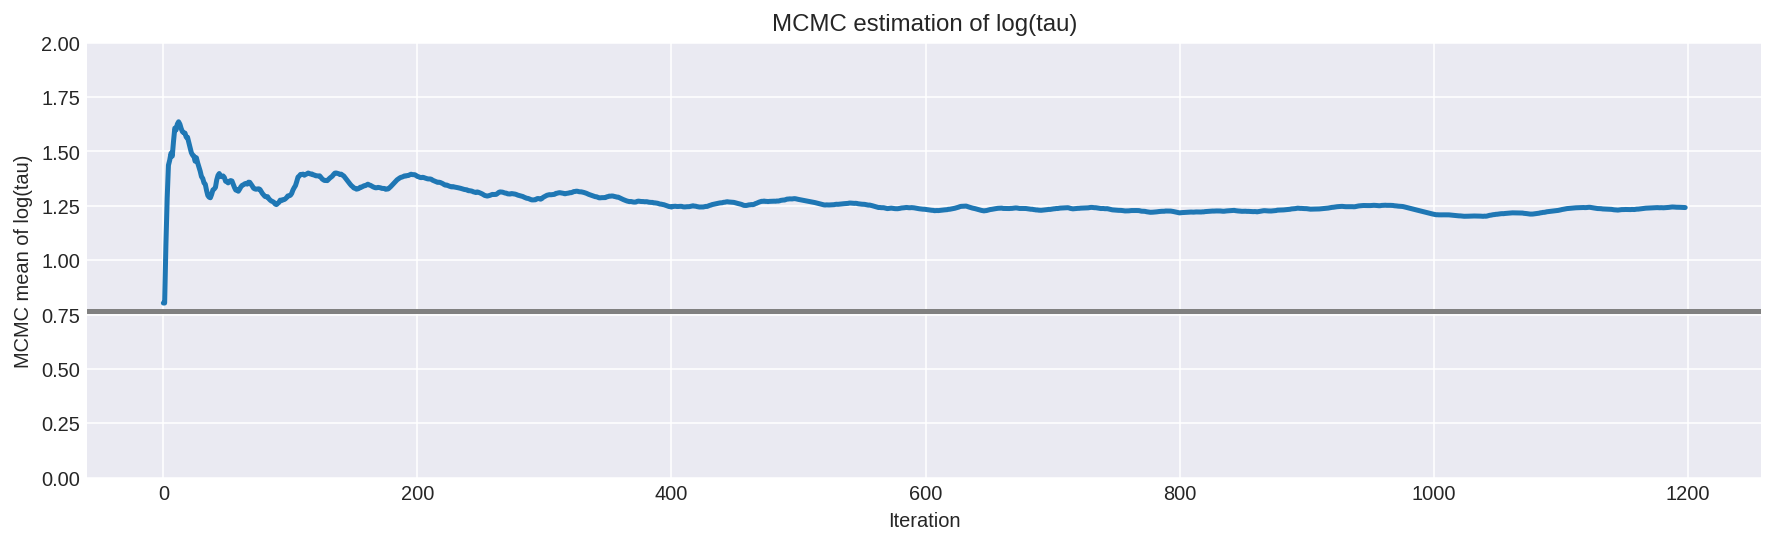

In [7]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');

> Hamiltonian Monte Carlo, however, is not so oblivious to these issues as 2% of the iterations in our lone Markov chain ended with a divergence.

In [8]:
# display the total number and percentage of divergent
divergent = short_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(short_trace)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 2
Percentage of Divergent 0.00333


> Even with a single short chain these divergences are able to identity the bias and advise skepticism of any resulting MCMC estimators.

> Additionally, because the divergent transitions, here shown here in green, tend to be located near the pathologies we can use them to identify the location of the problematic neighborhoods in parameter space.

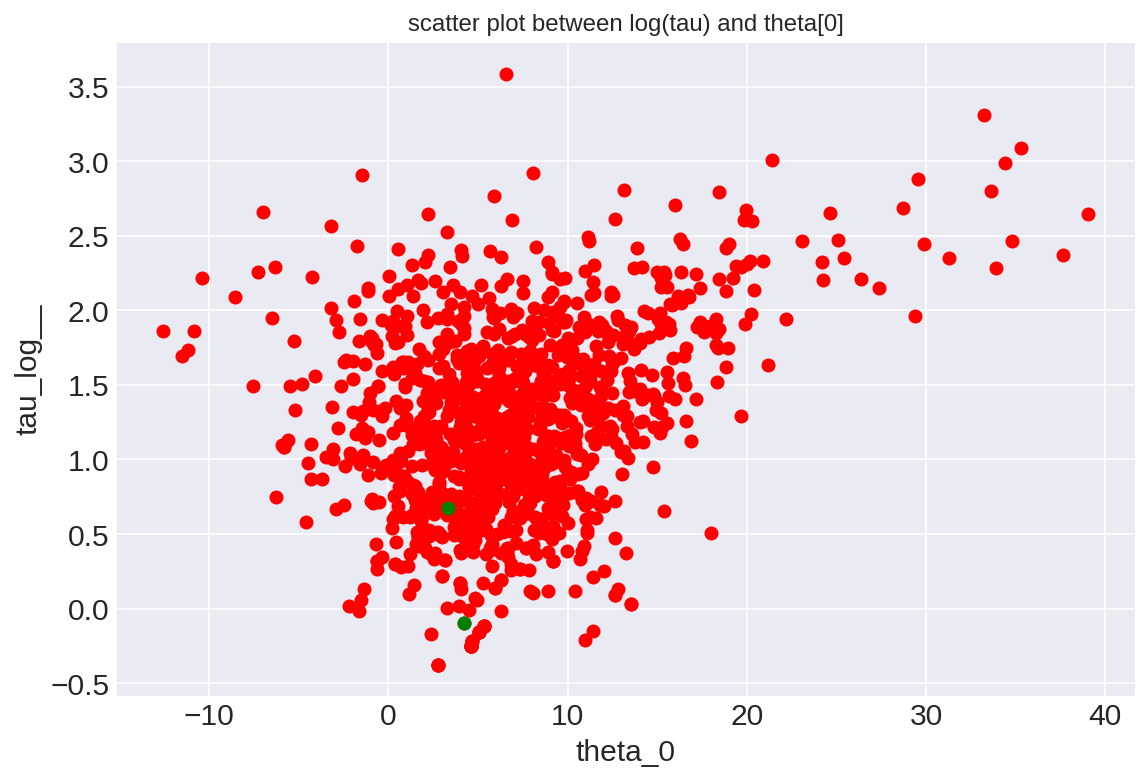

In [9]:
pm.scatterplot(short_trace,
               sub_varnames=['theta_0','tau_log__'],
               ax=None, 
               divergences=True, 
               plot_transformed=True,
               color='red', figsize=(15, 10), kwargs_divergence={'color':'green'})
plt.title('scatter plot between log(tau) and theta[0]');

It is important to point out that the pathological samples from the trace are not necessarily concentrated at the funnel: when a divergence is encountered, the subtree being constructed is rejected and the transition samples uniformly from the existing discrete trajectory. Consequently, divergent samples will not be located exactly in the region of high curvature.

In `pymc3`, we recently implemented a warning system that also saves the information of _where_ the divergence occurs, which you can also visualise them directly. To be more precise, what we include as the divergence point in the warning is the point where that problematic leapfrog step started. Some could also be because the divergence happens in one of the leapfrog step (which strictly speaking is not a point). But nonetheless, visualizing these should give a closer proximate where the funnel is.

Notices that only the first 100 divergences are stored, so that we don't eat all memory.

In [10]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

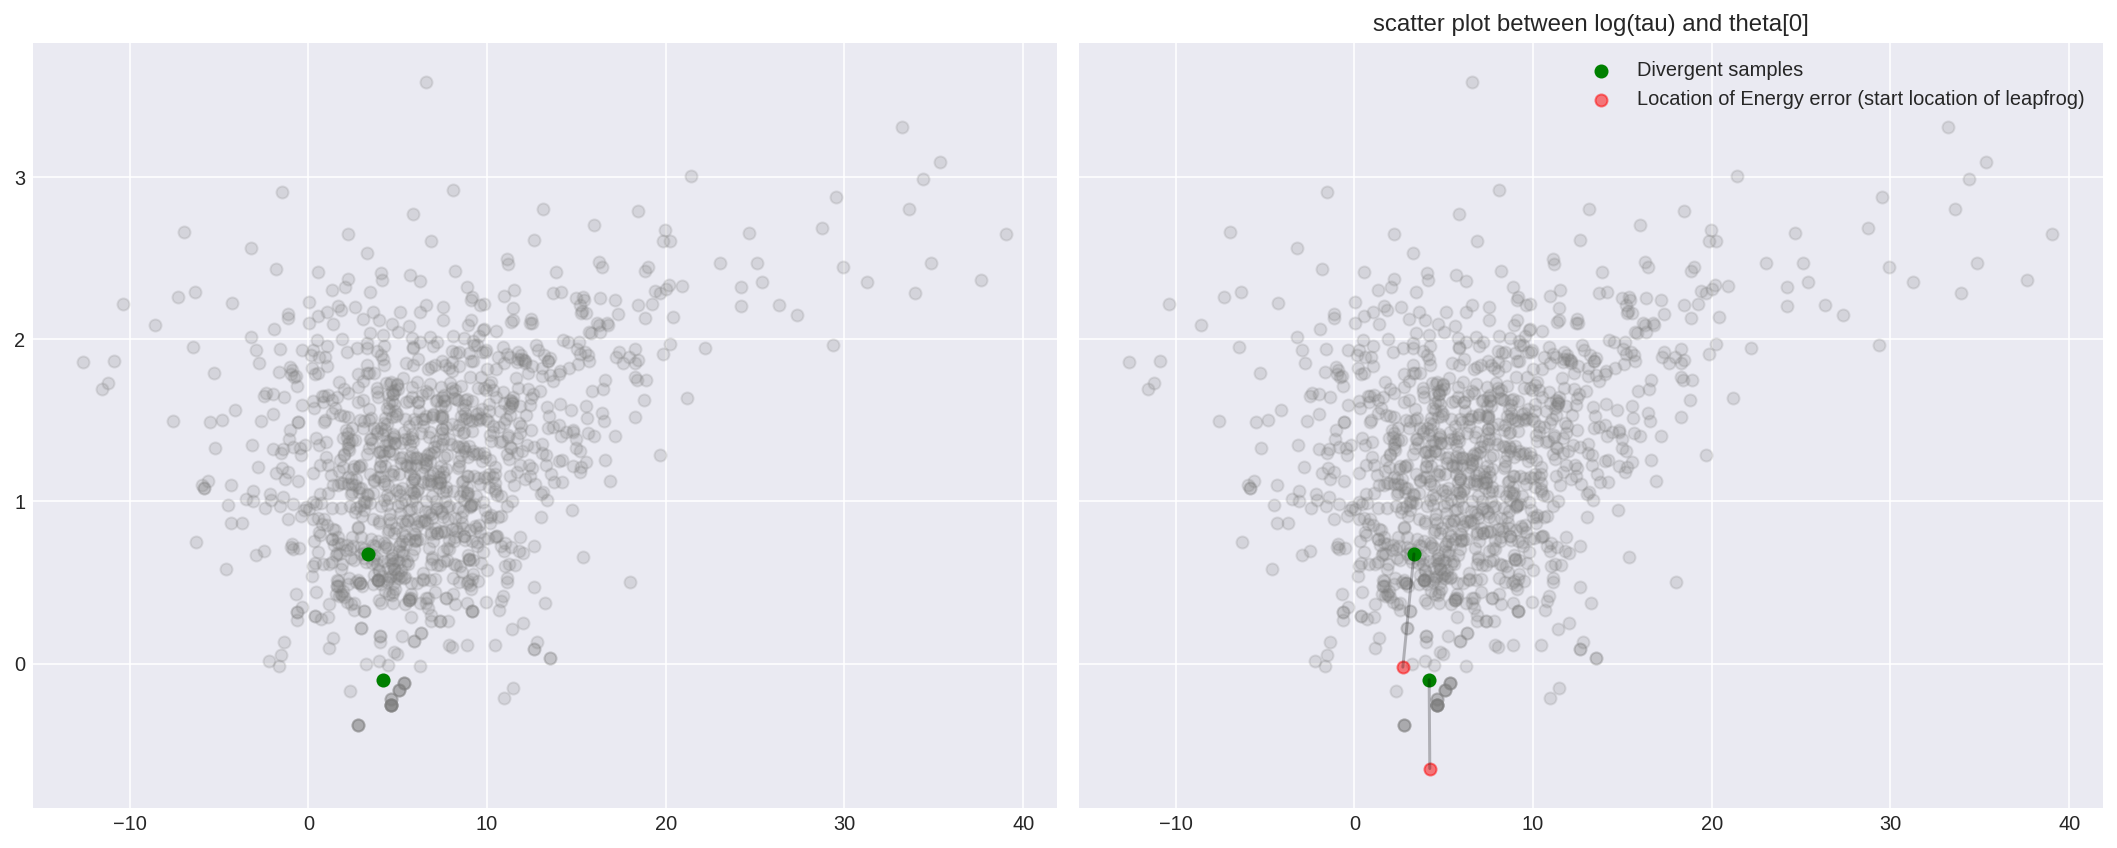

In [11]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

pm.scatterplot(short_trace,
               sub_varnames=['theta_0', 'tau_log__'],
               divergences=True,
               ax=ax[0],
               plot_transformed=True,
               color='C7', figsize=(12, 10), alpha=0.2, 
               kwargs_divergence={'color':'green'})

plt.title('scatter plot between log(tau) and theta[5]')

pm.scatterplot(short_trace,
               sub_varnames=['theta_0', 'tau_log__'], 
               divergences=True,
               ax=ax[1],
               plot_transformed=True,
               color='C7', alpha=0.2, figsize=(12, 10), 
               kwargs_divergence={'color':'green', 'label':'Divergent samples'})

theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]

plt.plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.25)

plt.scatter(theta0_d, tau_log_d, 
              color='r', alpha=.5, label='Location of Energy error (start location of leapfrog)')

plt.title('scatter plot between log(tau) and theta[0]')
plt.legend();

There are many other ways to explore and visualize the pathological region in the parameter space. For example, we can reproduce Figure 5b in [Visualization in Bayesian workflow](https://arxiv.org/pdf/1709.01449.pdf)

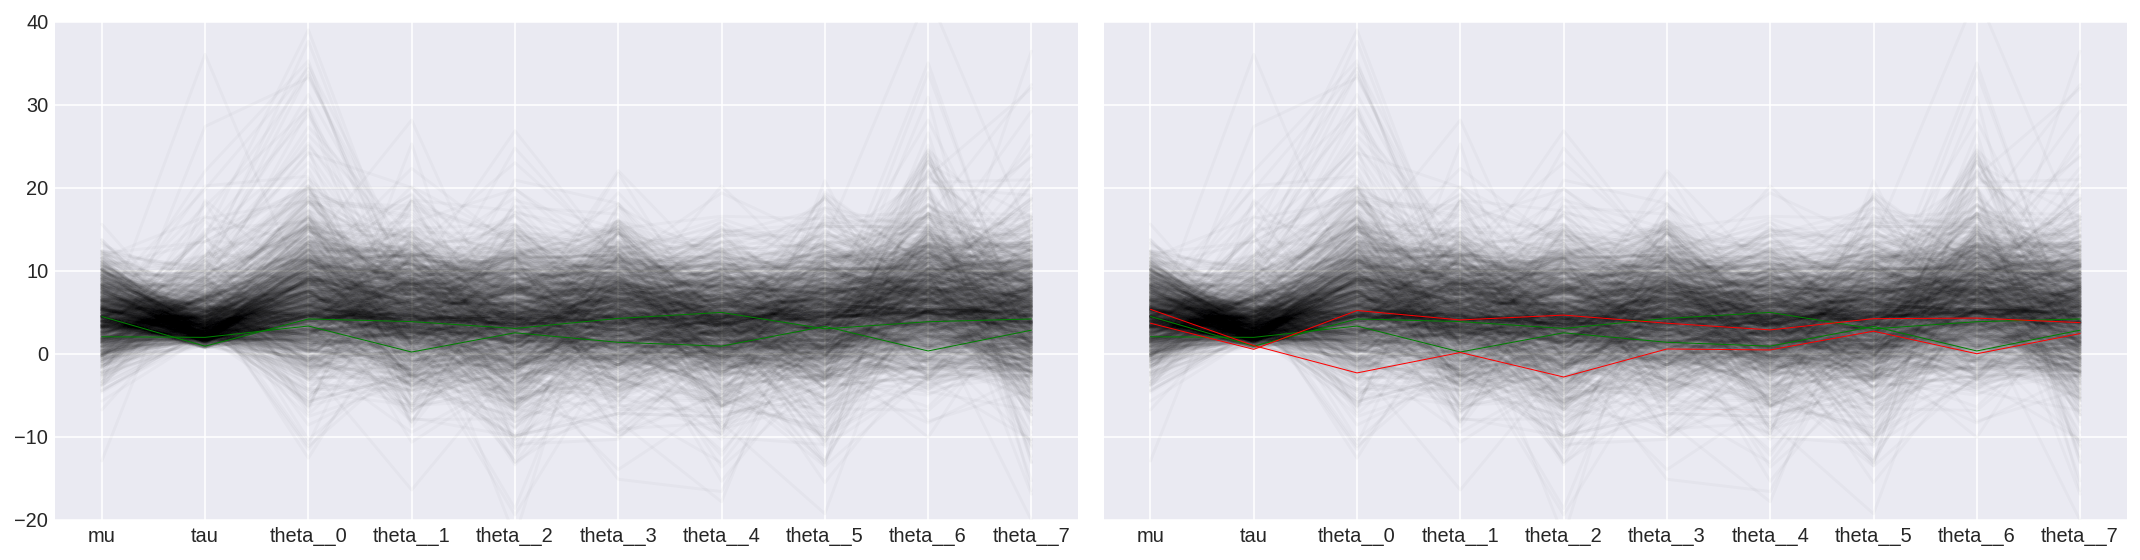

In [12]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
       'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='g', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='g', lw=.5)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'r', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

In [13]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace):
    # plot the trace of log(tau)
    pm.traceplot(trace, varnames=['tau'])
    
    # plot the estimate for the mean of log(τ) cumulating mean
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    plt.show()
    
    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)
    
    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pm.scatterplot(short_trace,
               sub_varnames=['theta_0', 'tau_log__'], 
               divergences=True, 
               plot_transformed=True,
               color='red', figsize=(15, 10), kwargs_divergence={'color':'green'})
    plt.title('scatter plot between log(tau) and theta[0]');
    plt.show()

### A Safer, Longer Markov Chain  
> 
Given the potential insensitivity of split $\hat{R}$ on single short chains, `Stan` recommend always running multiple chains as long as possible to have the best chance to observe any obstructions to geometric ergodicity. Because it is not always possible to run long chains for complex models, however, divergences are an incredibly powerful diagnostic for biased MCMC estimation.  

In [14]:
with Centered_eight:
    longer_trace = pm.sample(4000, chains=2, tune=1000, random_seed=SEED)

100%|██████████| 5000/5000 [01:23<00:00, 59.69it/s]


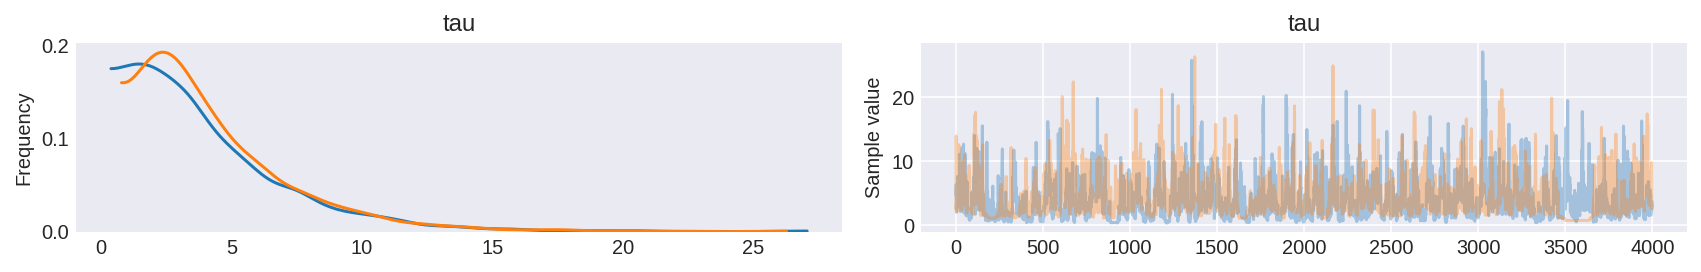

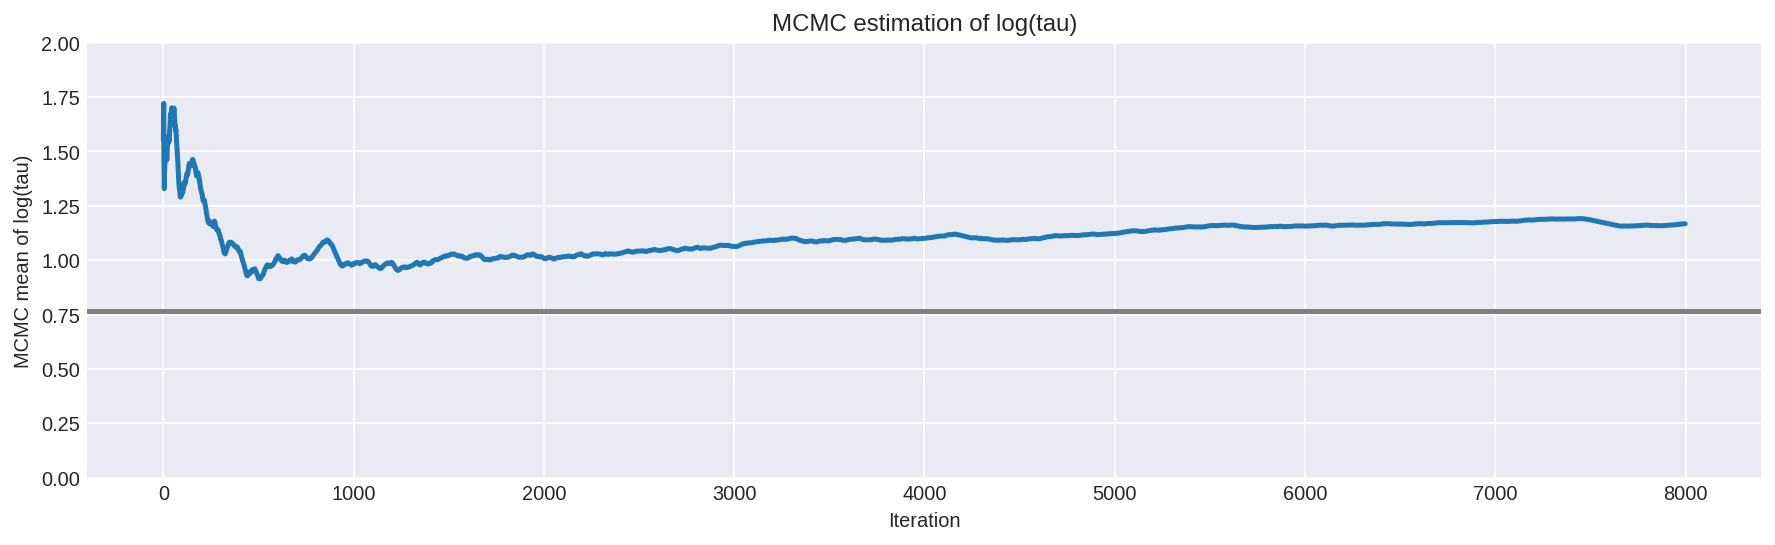

Number of Divergent 140
Percentage of Divergent 0.03500


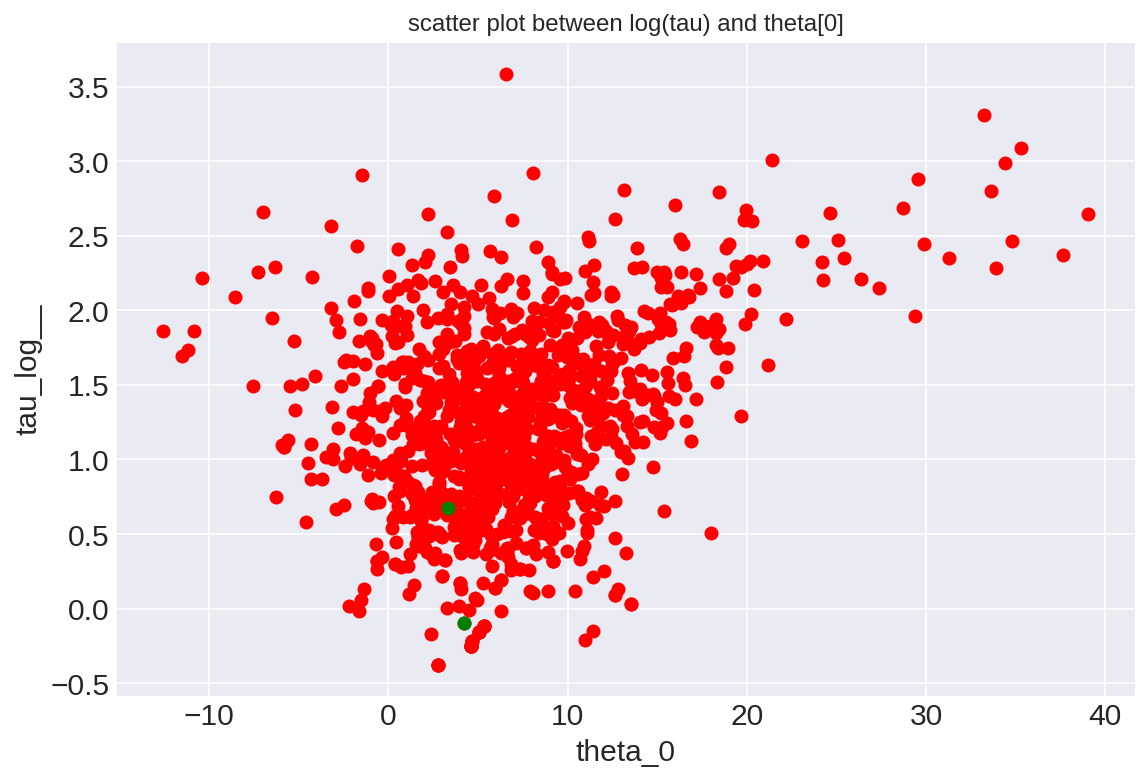

In [15]:
report_trace(longer_trace)

In [16]:
pm.summary(longer_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.390976,3.255843,0.089298,-2.718623,10.497963,1320.0,0.999902
theta__0,6.513693,5.584612,0.117685,-3.871323,18.481434,2111.0,0.999909
theta__1,5.008203,4.840895,0.100363,-4.498776,14.871399,2884.0,0.999881
theta__2,3.818791,5.584928,0.109726,-7.578697,15.221628,2135.0,0.999946
theta__3,4.820023,4.935208,0.102329,-5.116484,14.939917,2728.0,1.000043
theta__4,3.430150,4.880028,0.109635,-6.154613,13.227955,1643.0,0.999875
theta__5,4.007137,5.024076,0.096972,-6.560350,13.930499,2533.0,0.999876
theta__6,6.631228,5.345891,0.122096,-2.992235,17.753764,1927.0,0.999875
theta__7,4.890093,5.324986,0.093218,-5.731556,15.651837,3019.0,0.999975
tau,4.160336,3.075347,0.112997,0.395108,10.228912,495.0,1.001671


> 
Similar to the result in `Stan`,  $\hat{R}$ does not indicate any serious issues. However, the effective sample size per iteration has drastically fallen, indicating that we are exploring less efficiently the longer we run. This odd behavior is a clear sign that something problematic is afoot. As shown in the trace plot, the chain occasionally "sticking" as it approaches small values of $\tau$, exactly where we saw the divergences concentrating. This is a clear indication of the underlying pathologies. These sticky intervals induce severe oscillations in the MCMC estimators early on, until they seem to finally settle into biased values.   
> 
In fact the sticky intervals are the Markov chain trying to correct the biased exploration. If we ran the chain even longer then it would eventually get stuck again and drag the MCMC estimator down towards the true value. Given an infinite number of iterations this delicate balance asymptotes to the true expectation as we’d expect given the consistency guarantee of MCMC. Stopping the after any finite number of iterations, however, destroys this balance and leaves us with a significant bias. 

More details can be found in Betancourt's [recent paper](https://arxiv.org/abs/1701.02434).  

## Mitigating Divergences by Adjusting PyMC3's Adaptation Routine
> 
Divergences in Hamiltonian Monte Carlo arise when the Hamiltonian transition encounters regions of extremely large curvature, such as the opening of the hierarchical funnel. Unable to accurate resolve these regions, the transition malfunctions and flies off towards infinity. With the transitions unable to completely explore these regions of extreme curvature, we lose geometric ergodicity and our MCMC estimators become biased.
> 
Algorithm implemented in `Stan` uses a heuristic to quickly identify these misbehaving trajectories, and hence label divergences, without having to wait for them to run all the way to infinity. This heuristic can be a bit aggressive, however, and sometimes label transitions as divergent even when we have not lost geometric ergodicity.
> 
To resolve this potential ambiguity we can adjust the step size, $\epsilon$, of the Hamiltonian transition. The smaller the step size the more accurate the trajectory and the less likely it will be mislabeled as a divergence. In other words, if we have geometric ergodicity between the Hamiltonian transition and the target distribution then decreasing the step size will reduce and then ultimately remove the divergences entirely. If we do not have geometric ergodicity, however, then decreasing the step size will not completely remove the divergences.

Like `Stan`, the step size in `PyMC3` is tuned automatically during warm up, but we can coerce smaller step sizes by tweaking the configuration of `PyMC3`'s adaptation routine. In particular, we can increase the `target_accept` parameter from its default value of 0.8 closer to its maximum value of 1.

### Adjusting Adaptation Routine

In [17]:
with Centered_eight:
    fit_cp85 = pm.sample(5000, chains=2, tune=2000,
                         nuts_kwargs=dict(target_accept=.85))

100%|██████████| 7000/7000 [02:58<00:00, 39.15it/s]


In [18]:
with Centered_eight:
    fit_cp90 = pm.sample(5000, chains=2, tune=2000,
                         nuts_kwargs=dict(target_accept=.90))

100%|██████████| 7000/7000 [04:32<00:00, 25.68it/s]


In [19]:
with Centered_eight:
    fit_cp95 = pm.sample(5000, chains=2, tune=2000,
                         nuts_kwargs=dict(target_accept=.95))

100%|██████████| 7000/7000 [04:46<00:00, 24.45it/s]


In [20]:
with Centered_eight:
    fit_cp99 = pm.sample(5000, chains=2, tune=2000,
                         nuts_kwargs=dict(target_accept=.99))

100%|██████████| 7000/7000 [10:12<00:00, 11.43it/s]


In [21]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                  fit_cp85['step_size'].mean(),
                  fit_cp90['step_size'].mean(),
                  fit_cp95['step_size'].mean(),
                  fit_cp99['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                            fit_cp85['diverging'].sum(),
                            fit_cp90['diverging'].sum(),
                            fit_cp95['diverging'].sum(),
                            fit_cp99['diverging'].sum()])
df['delta_target'] = pd.Series(['.80', '.85', '.90', '.95', '.99'])
df

,Step_size,Divergent,delta_target
0,0.269821,140,.80
1,0.179626,236,.85
2,0.064507,403,.90
3,0.174937,153,.95
4,0.049343,10,.99


Here, the number of divergent transitions dropped dramatically when delta was increased to 0.99. 
> 
This behavior also has a nice geometric intuition. The more we decrease the step size the more the Hamiltonian Markov chain can explore the neck of the funnel. Consequently, the marginal posterior distribution for $log (\tau)$ stretches further and further towards negative values with the decreasing step size. 

Since in `PyMC3` after tuning we have a smaller step size than `Stan`, the geometery is better explored.
> 
However, the Hamiltonian transition is still not geometrically ergodic with respect to the centered implementation of the Eight Schools model. Indeed, this is expected given the observed bias.

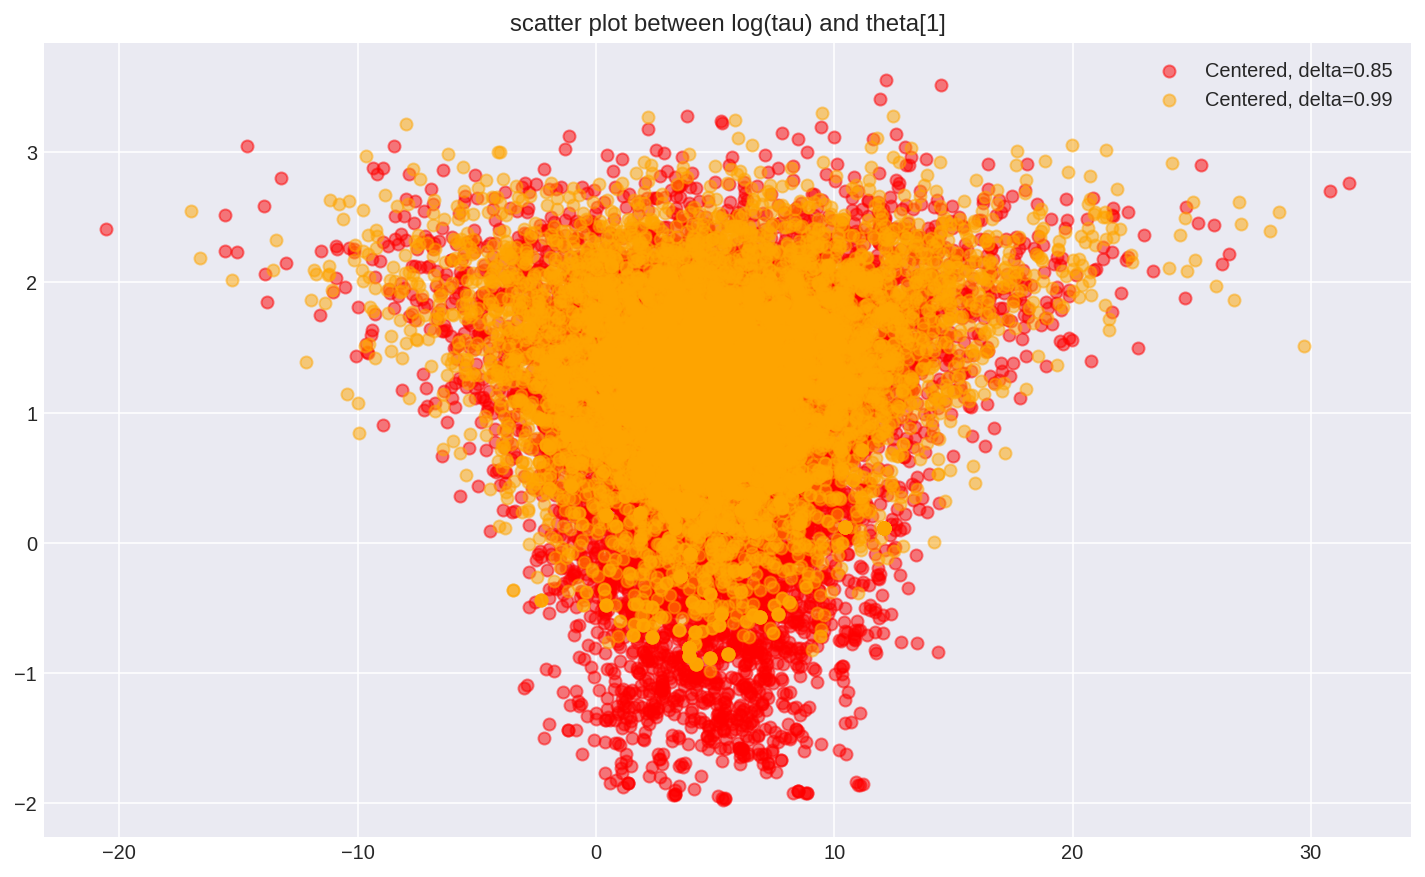

In [22]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pm.scatterplot(fit_cp99, sub_varnames=['theta_1', 'tau_log__'], plot_transformed=True, ax=ax,
               color='red', alpha=0.5, label='Centered, delta=0.85')

pm.scatterplot(longer_trace, sub_varnames=['theta_1', 'tau_log__'], plot_transformed=True, ax=ax,
               color='orange', alpha=0.5, label='Centered, delta=0.99')

plt.title('scatter plot between log(tau) and theta[1]')
plt.legend();

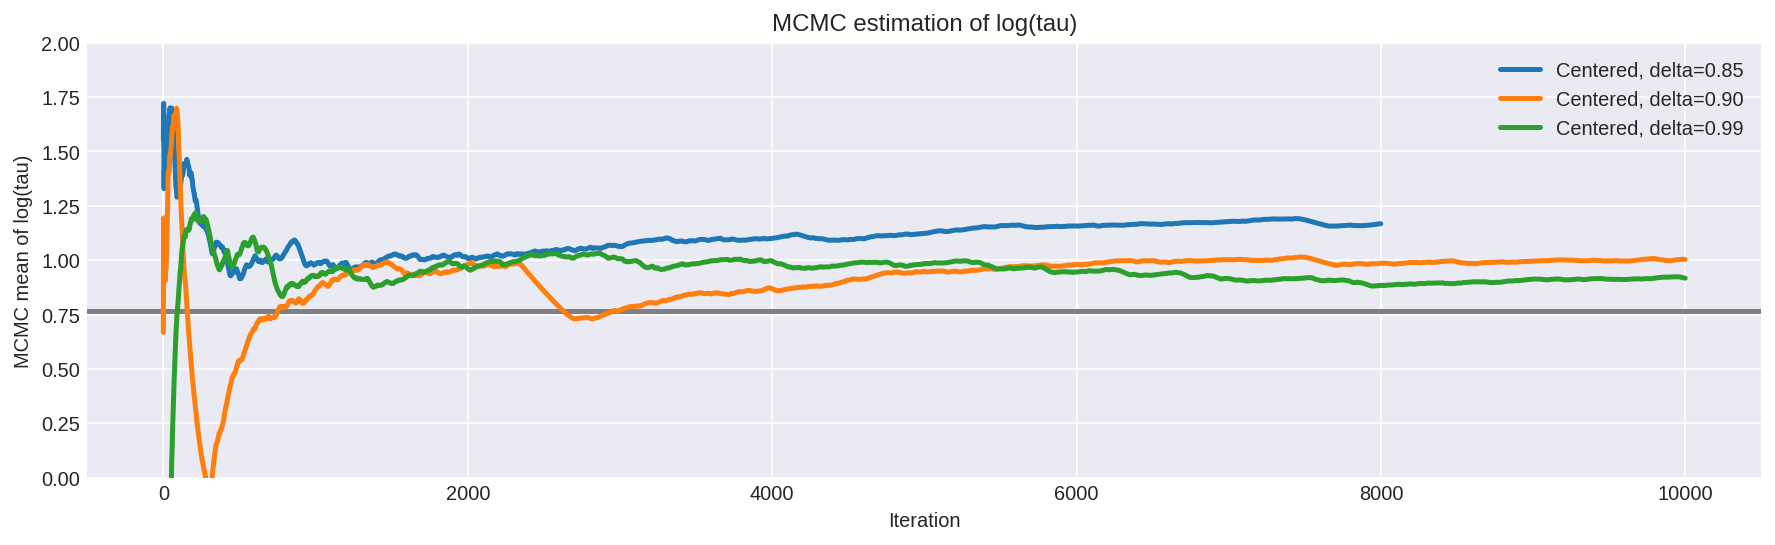

In [33]:
logtau0 = np.log(longer_trace['tau'])
logtau2 = np.log(fit_cp90['tau'])
logtau1 = np.log(fit_cp99['tau'])
logtaun = np.log(fit_ncp80['tau'])

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.85', lw=2.5)
mlogtau2 = [np.mean(logtau2[:i]) for i in np.arange(1, len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90', lw=2.5)
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99', lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();

## A Non-Centered Eight Schools Implementation  
> 
Although reducing the step size improves exploration, ultimately it only reveals the true extent the pathology in the centered implementation. Fortunately, there is another way to implement hierarchical models that does not suffer from the same pathologies.  
> 
In a non-centered parameterization we do not try to fit the group-level parameters directly, rather we fit a latent Gaussian variable from which we can recover the group-level parameters with a scaling and a translation.  
> 
$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\tilde{\theta}_{n} \sim \mathcal{N}(0, 1)$$
$$\theta_{n} = \mu + \tau \cdot \tilde{\theta}_{n}.$$

Stan model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
```

In [26]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [27]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                         nuts_kwargs=dict(target_accept=.80))

100%|██████████| 6000/6000 [00:19<00:00, 306.81it/s]


In [28]:
pm.summary(fit_ncp80)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.409769,3.301790,0.028434,-1.859142,10.965260,10000.0,1.000063
theta_t__0,0.313990,0.986608,0.007827,-1.634825,2.240131,10000.0,0.999960
theta_t__1,0.089655,0.943818,0.008952,-1.734256,1.964699,10000.0,0.999928
theta_t__2,-0.075925,0.976639,0.007311,-1.954732,1.899746,10000.0,0.999901
theta_t__3,0.064413,0.934334,0.007126,-1.733679,1.894388,10000.0,1.000072
theta_t__4,-0.163410,0.934758,0.008421,-2.037900,1.609486,10000.0,0.999965
theta_t__5,-0.067254,0.927271,0.006922,-1.881492,1.769921,10000.0,0.999900
theta_t__6,0.358521,0.965593,0.008533,-1.571699,2.219523,10000.0,0.999902
theta_t__7,0.073238,0.968746,0.008265,-1.858223,1.932444,10000.0,0.999954
tau,3.602494,3.168994,0.037367,0.000242,10.080262,6028.0,0.999992


> 
As shown above, the effective sample size per iteration has drastically improved, and the trace plots no longer show any "stickyness". However, we do still see the rare divergence. These infrequent divergences do not seem concentrate anywhere in parameter space, which is indicative of the divergences being false positives.

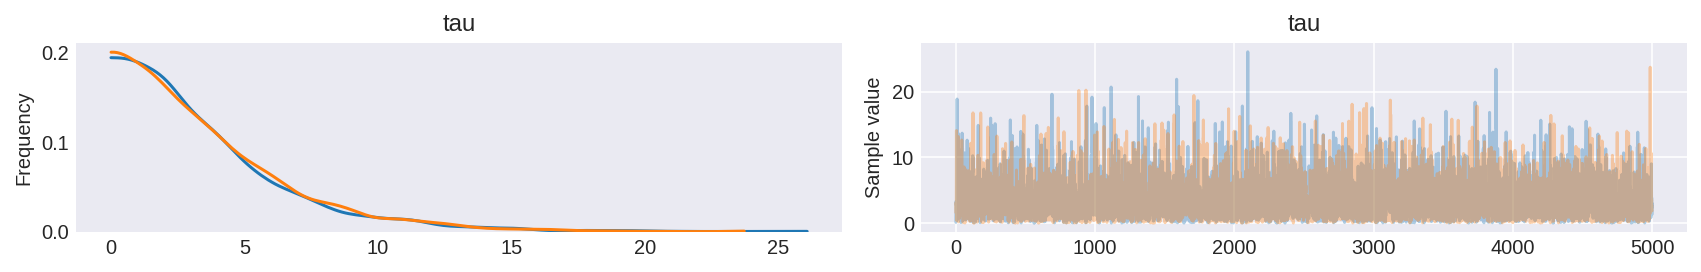

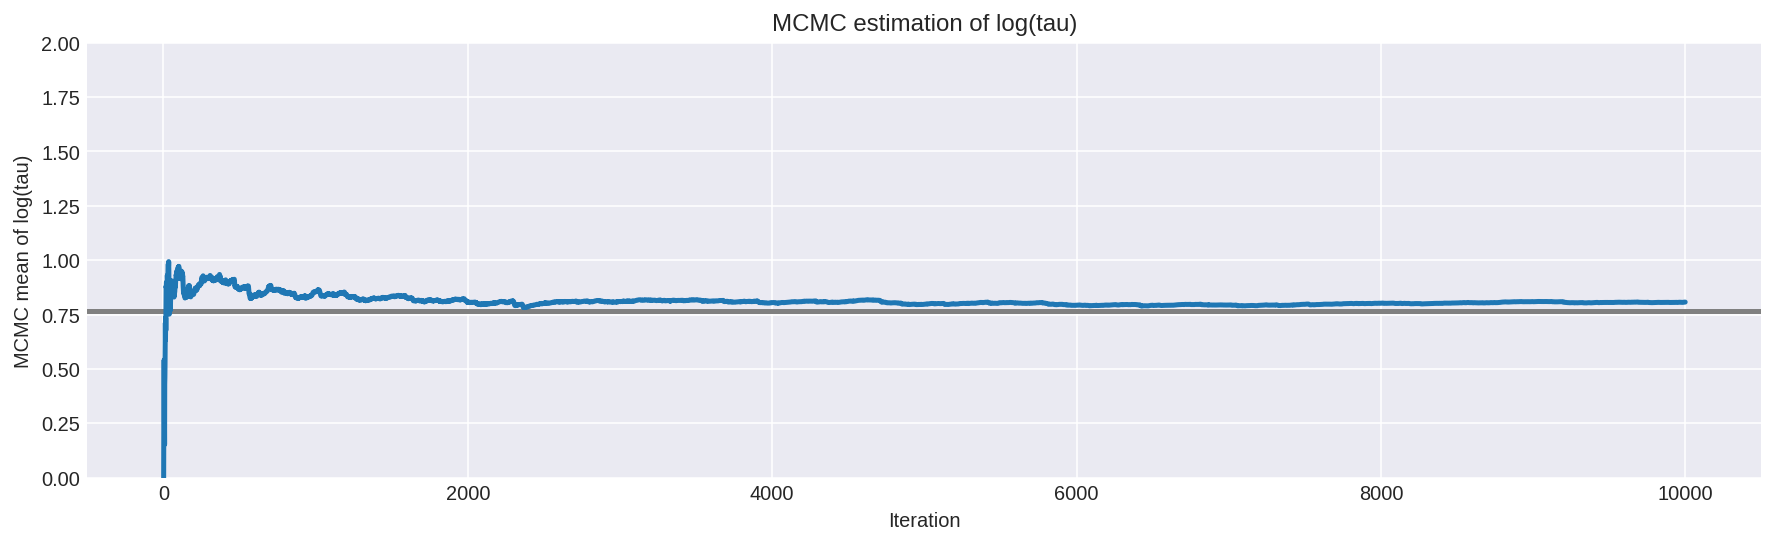

Number of Divergent 2
Percentage of Divergent 0.00040


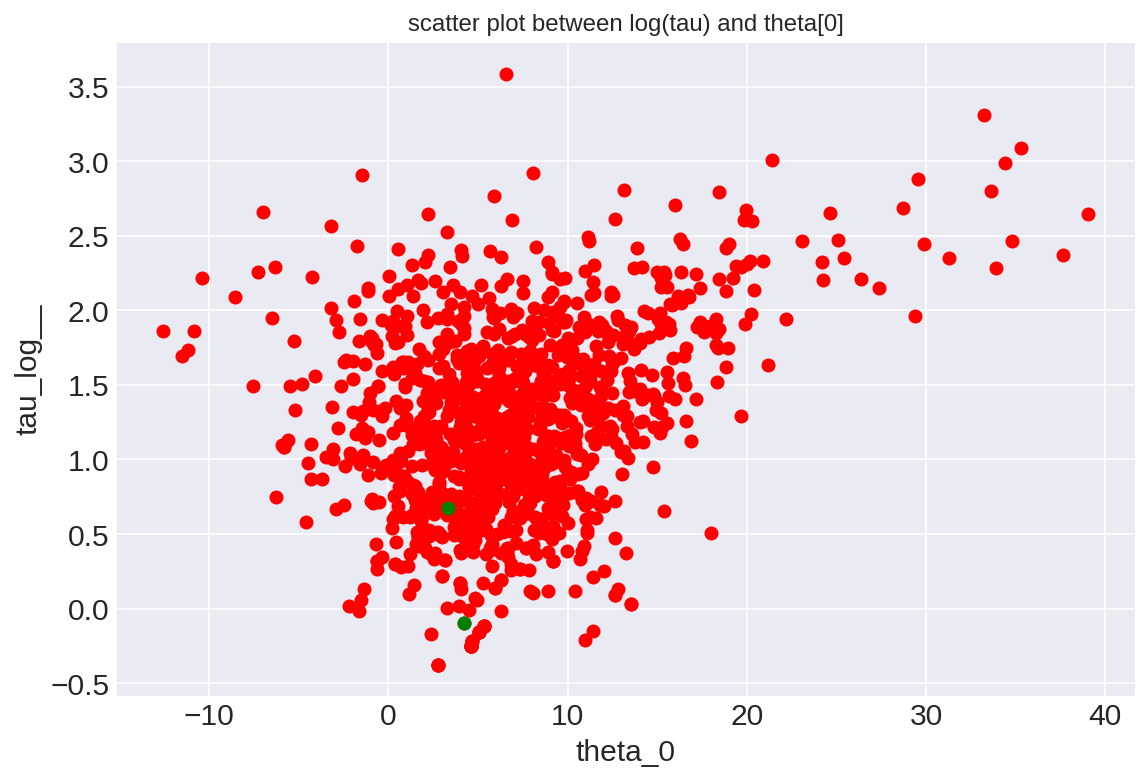

In [29]:
report_trace(fit_ncp80)

> As expected of false positives, we can remove the divergences entirely by decreasing the step size,

In [30]:
with NonCentered_eight:
    fit_ncp90 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                         nuts_kwargs=dict(target_accept=.90))
    
# display the total number and percentage of divergent
divergent = fit_ncp90['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)

100%|██████████| 6000/6000 [01:34<00:00, 63.21it/s] 


Number of Divergent 0


> The more agreeable geometry of the non-centered implementation allows the Markov chain to explore deep into the neck of the funnel, capturing even the smallest values of $\tau$ that are consistent with the measurements. Consequently, MCMC estimators from the non-centered chain rapidly converge towards their true expectation values.

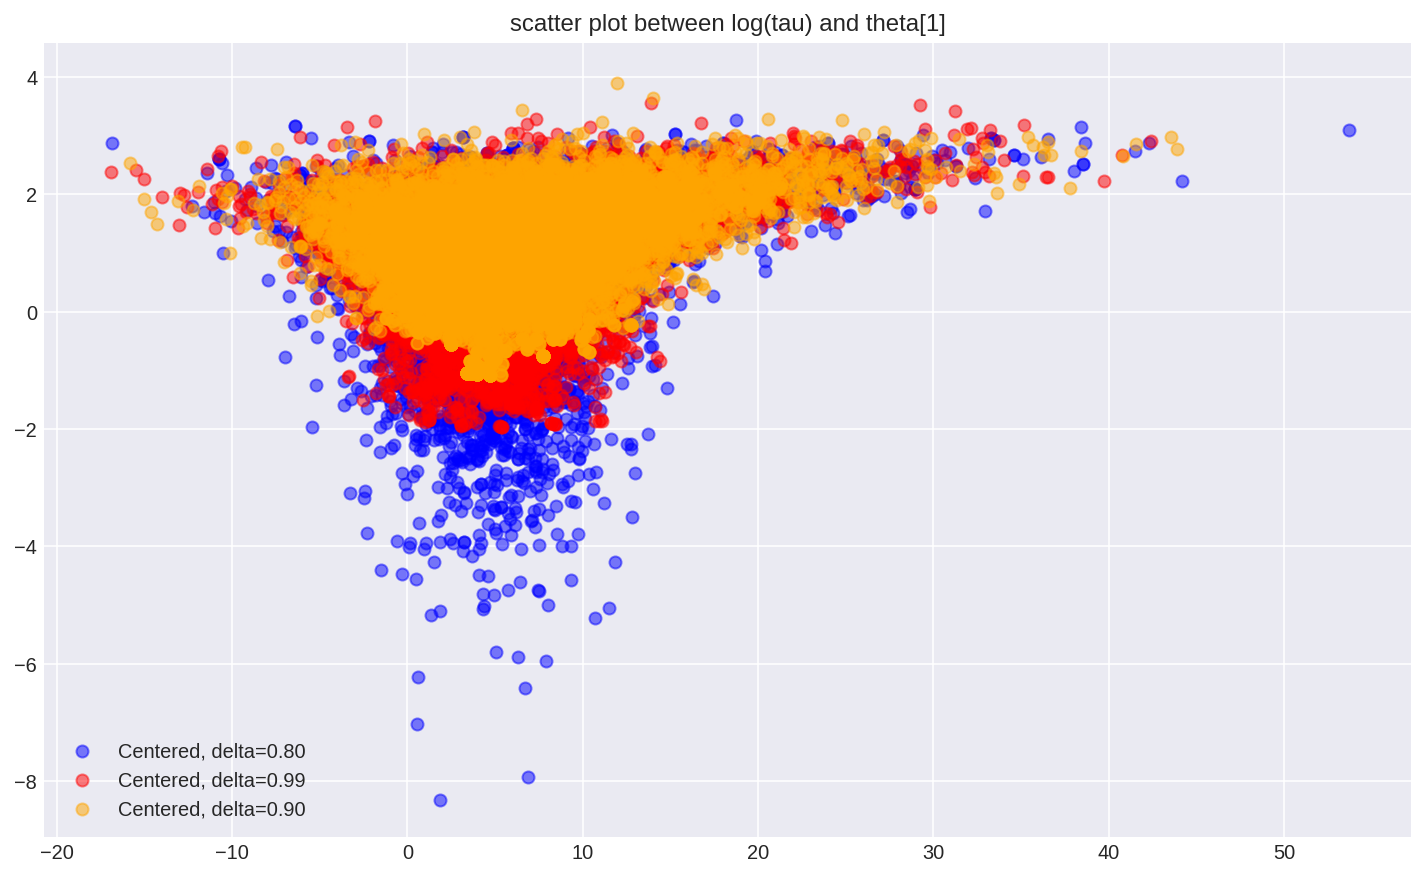

In [31]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pm.scatterplot(fit_ncp80, sub_varnames=['theta_0', 'tau_log__'], plot_transformed=True, ax=ax,
               color='blue', alpha=0.5, label='Centered, delta=0.80')

pm.scatterplot(fit_cp99, sub_varnames=['theta_0', 'tau_log__'], plot_transformed=True, ax=ax,
               color='red', alpha=0.5, label='Centered, delta=0.99')

pm.scatterplot(fit_cp90, sub_varnames=['theta_0', 'tau_log__'], plot_transformed=True, ax=ax,
               color='orange', alpha=0.5, label='Centered, delta=0.90')
plt.title('scatter plot between log(tau) and theta[1]')
plt.legend();

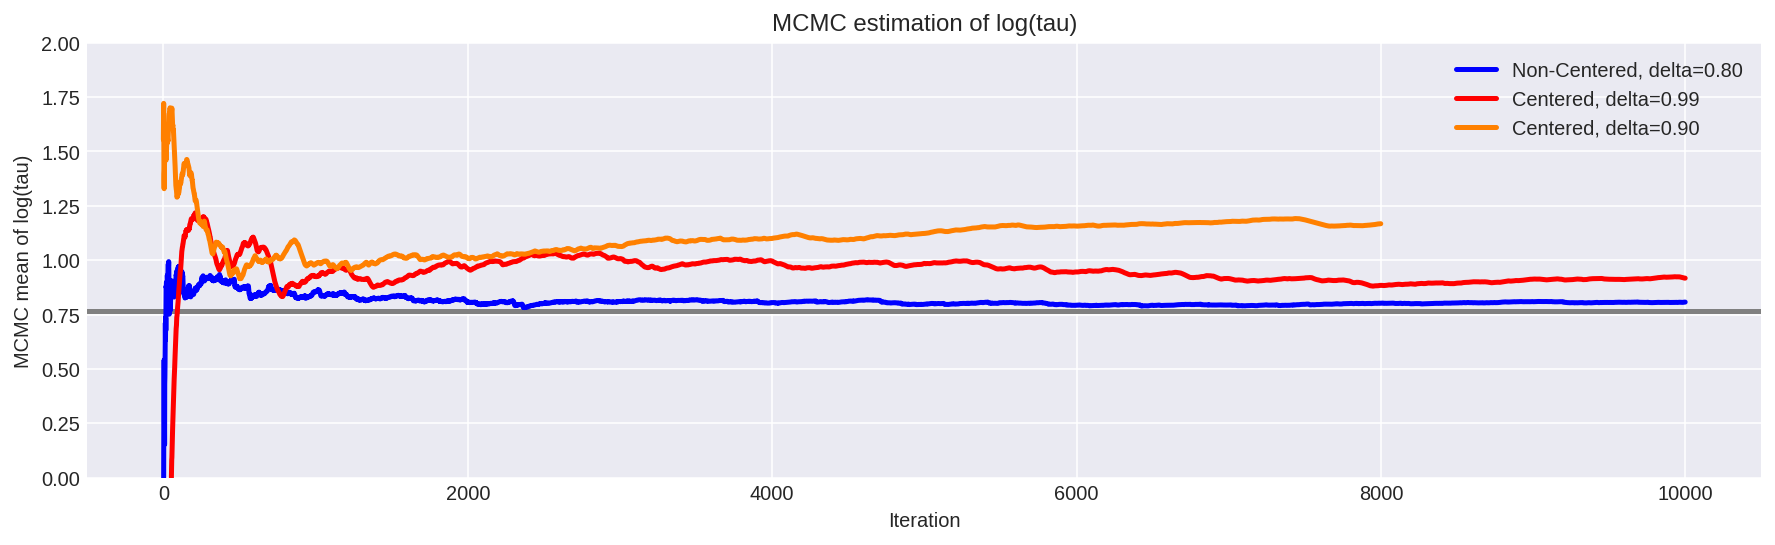

In [34]:
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun, color='b', lw=2.5, label='Non-Centered, delta=0.80')

mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, color='r', lw=2.5, label='Centered, delta=0.99')

mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, color=[1, 0.5, 0], lw=2.5, label='Centered, delta=0.90')
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();